In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
df_train = pd.read_csv("train_sentiment.csv")
df_test = pd.read_csv("test_sentiment.csv")

In [4]:
train_x, train_y, test_x, test_y = df_train["review"], df_train["sentiment"], df_test["review"], df_test["sentiment"]
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [5]:
def build_vocab(texts, max_vocab_size):
    counter = Counter()
    for sentence in texts:
        counter.update(sentence.split())
        
    vocab = {
        "<PAD>": 0,
        "<OOV>": 1,
    }
    
    for idx, (word, _) in enumerate(
        counter.most_common(max_vocab_size - 2), start=2
    ):
        vocab[word] = idx
        
    return vocab

In [6]:
max_vocab_size = 10000
vocab = build_vocab(train_x.values, max_vocab_size)

In [7]:
def texts_to_sequences(texts, vocab):
    sequences = []
    
    for sentence in texts:
        seq = [
            vocab.get(word, vocab["<OOV>"])
            for word in sentence.split()
        ]
        sequences.append(seq)
        
    return sequences

In [8]:
train_x = texts_to_sequences(train_x.values, vocab)
val_x = texts_to_sequences(val_x.values, vocab)
test_x = texts_to_sequences(test_x.values, vocab)

In [9]:
def pad(sequences, pad_value=0):
    return pad_sequence(
        [torch.tensor(seq, dtype=torch.long) for seq in sequences],
        batch_first=True,
        padding_value=pad_value
    )

In [10]:
train_x = pad(train_x, pad_value=0)
val_x = pad(val_x, pad_value=0)
test_x = pad(test_x, pad_value=0)
train_y = torch.tensor(train_y.values, dtype=torch.float32)
val_y = torch.tensor(val_y.values, dtype=torch.float32)
test_y = torch.tensor(test_y.values, dtype=torch.float32)

In [11]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=2)
        
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.max(x, dim=2).values
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x).squeeze(1)

In [12]:
model = TextCNN(vocab_size=len(vocab), embedding_dim=64)

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
train_losses = []
val_losses = []

epochs = 3
batch_size = 64

for epoch in range(epochs):
    model.train()
    running_training_loss = 0.0
    
    for i in range(0, len(train_x), batch_size):
        x_batch = train_x[i:i+batch_size]
        y_batch = train_y[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_training_loss += loss.item()
        
    avg_train_loss = running_training_loss / (len(train_x) // batch_size)
    train_losses.append(avg_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        x_val = val_x
        y_val = val_y
        
        outputs = model(x_val)
        val_loss = criterion(outputs, y_val)
        running_val_loss += val_loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5)
        
        correct = (preds == y_val).sum().item()
    
    avg_val_loss = running_val_loss
    val_losses.append(avg_val_loss)
    
    val_acc = correct / len(y_val)
    
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train loss: {avg_train_loss:.4f} | "
        f"Val loss: {avg_val_loss:.4f} | "
        f"Val acc: {val_acc:.4f}"
    )

Epoch 1/3 | Train loss: 0.0017 | Val loss: 0.0008 | Val acc: 1.0000
Epoch 2/3 | Train loss: 0.0006 | Val loss: 0.0007 | Val acc: 1.0000
Epoch 3/3 | Train loss: 0.0006 | Val loss: 0.0003 | Val acc: 1.0000


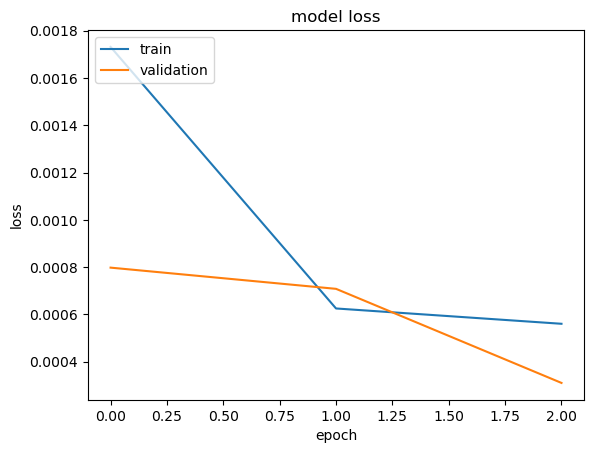

In [16]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
model.eval()

with torch.no_grad():
    x_test = test_x
    y_test = test_y
    outputs = model(x_test)
    preds = (torch.sigmoid(outputs) >= 0.5)
    test_acc = (preds == y_test).sum().item()
    
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 1000.0000


In [22]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

reviews = pd.concat([df_train["review"], df_test["review"]], axis=0)
sentiments = pd.concat([df_train["sentiment"], df_test["sentiment"]], axis=0)

X_tfidf = vectorizer.fit_transform(reviews)

In [23]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_tfidf.toarray())

In [24]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

In [25]:
ari = adjusted_rand_score(sentiments, clusters)
h, c, v = homogeneity_completeness_v_measure(sentiments, clusters)

print(f"ARI: {ari:.4f}")
print(f"Homogeneity: {h:.4f} | Completeness: {c:.4f} | V-measure: {v:.4f}")


ARI: 1.0000
Homogeneity: 1.0000 | Completeness: 1.0000 | V-measure: 1.0000


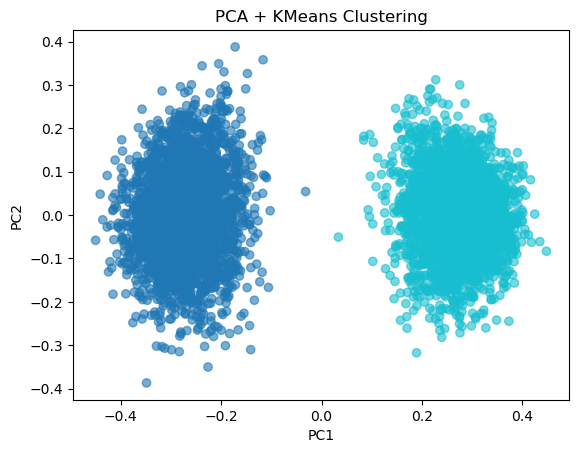

In [26]:
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=clusters,
    cmap="tab10",
    alpha=0.6
)
plt.title("PCA + KMeans Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()